# Beijing Air Quality Forecasting (PM2.5) — Starter Notebook

**Goal:** Predict PM2.5 concentrations using time-series aware modeling and minimize RMSE.


## Approach to the Challenge

This is a time-series forecasting problem where the objective is to predict **PM2.5** using historical meteorological and time-related variables.

### Overall strategy
1. **Explore** the dataset structure, missing values, and PM2.5 distribution/trends.
2. **Preprocess** data: parse and sort by time, handle missing values, and scale features.
3. **Feature engineering:** extract time-based features (hour/day-of-week/month).
4. **Sequence building (time windowing):** create sliding windows of past observations so the model learns temporal dependencies.
5. **Modeling:** use an **LSTM** (RNN variant) since it is designed for sequential data and helps address vanishing gradients via gating mechanisms.
6. **Experimentation:** systematically vary hyperparameters (window size, units, learning rate, batch size, layers) and track RMSE.

**Primary objective:** reduce validation RMSE and improve Kaggle private leaderboard score.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TF version:", tf.__version__)



TF version: 2.19.0


In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


In [3]:
BASE = Path("/content/drive/MyDrive")

def find_data_dir(base: Path) -> Path:
    candidates = list(base.rglob("train.csv"))
    # Prefer folder that has train.csv, test.csv, sample_submission.csv
    for train_path in candidates:
        d = train_path.parent
        if (d/"test.csv").exists() and (d/"sample_submission.csv").exists():
            return d
    # fallback: if only train.csv found, return its parent
    if candidates:
        return candidates[0].parent
    raise FileNotFoundError("Could not find train.csv under /content/drive/MyDrive")

DATA_DIR = find_data_dir(BASE)
print("Using DATA_DIR:", DATA_DIR)

print("train.csv exists:", (DATA_DIR/"train.csv").exists())
print("test.csv exists:", (DATA_DIR/"test.csv").exists())
print("sample_submission.csv exists:", (DATA_DIR/"sample_submission.csv").exists())


Using DATA_DIR: /content/drive/MyDrive/MyDrive air-quality data 
train.csv exists: True
test.csv exists: True
sample_submission.csv exists: True


In [4]:
train = pd.read_csv(DATA_DIR/"train.csv")
test = pd.read_csv(DATA_DIR/"test.csv")
sample_sub = pd.read_csv(DATA_DIR/"sample_submission.csv")

print("train:", train.shape, "test:", test.shape, "sample_sub:", sample_sub.shape)
train.head()


train: (30676, 12) test: (13148, 11) sample_sub: (13148, 2)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

## Data Exploration (EDA)

We examine:
- Columns and data types
- Missing values (especially target `pm2.5`)
- Summary statistics
- Visualizations: PM2.5 distribution + PM2.5 over time (sample)


In [5]:
print("Columns:", list(train.columns))
print("\nDtypes:\n", train.dtypes)

print("\nMissing values (train):\n", train.isna().sum().sort_values(ascending=False).head(15))
print("\nMissing values (test):\n", test.isna().sum().sort_values(ascending=False).head(15))

train.describe(include="all").transpose().head(20)


Columns: ['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']

Dtypes:
 No            int64
DEWP        float64
TEMP        float64
PRES        float64
Iws         float64
Is          float64
Ir          float64
datetime     object
cbwd_NW     float64
cbwd_SE     float64
cbwd_cv     float64
pm2.5       float64
dtype: object

Missing values (train):
 pm2.5       1921
No             0
TEMP           0
DEWP           0
PRES           0
Iws            0
Ir             0
Is             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
dtype: int64

Missing values (test):
 No          0
DEWP        0
TEMP        0
PRES        0
Iws         0
Is          0
Ir          0
datetime    0
cbwd_NW     0
cbwd_SE     0
cbwd_cv     0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
No,30676.0,NaN,NaN,NaN,15338.5,8855.542765,1.0,7669.75,15338.5,23007.25,30676.0
DEWP,30676.0,NaN,NaN,NaN,-0.029431,0.994087,-2.135153,-0.888034,-0.056622,0.913358,1.814055
TEMP,30676.0,NaN,NaN,NaN,-0.062712,1.015193,-2.57807,-0.938521,0.045209,0.864984,2.340578
PRES,30676.0,NaN,NaN,NaN,0.013612,1.008991,-2.380821,-0.82267,-0.043595,0.832865,2.877939
Iws,30676.0,NaN,NaN,NaN,0.030542,1.018337,-0.468688,-0.441894,-0.352512,0.005216,11.231956
Is,30676.0,NaN,NaN,NaN,0.016992,1.087278,-0.069353,-0.069353,-0.069353,-0.069353,35.439859
Ir,30676.0,NaN,NaN,NaN,0.011253,1.063811,-0.137667,-0.137667,-0.137667,-0.137667,25.288745
datetime,30676,30676,2013-07-02 03:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cbwd_NW,30676.0,NaN,NaN,NaN,0.016193,1.006001,-0.690542,-0.690542,-0.690542,1.448138,1.448138
cbwd_SE,30676.0,NaN,NaN,NaN,0.005833,1.001847,-0.732019,-0.732019,-0.732019,1.366085,1.366085


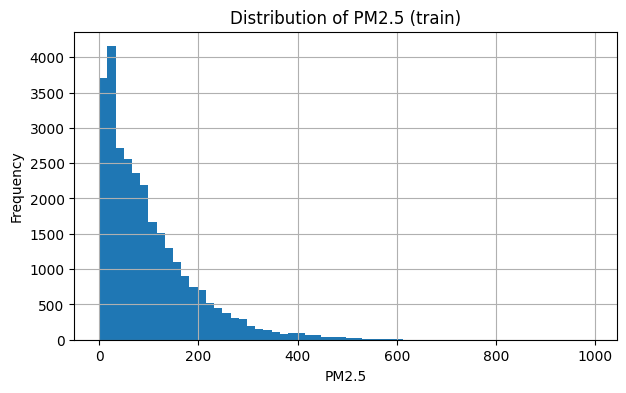

In [6]:
TARGET = "pm2.5"

plt.figure(figsize=(7,4))
plt.hist(train[TARGET].dropna(), bins=60)
plt.title("Distribution of PM2.5 (train)")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


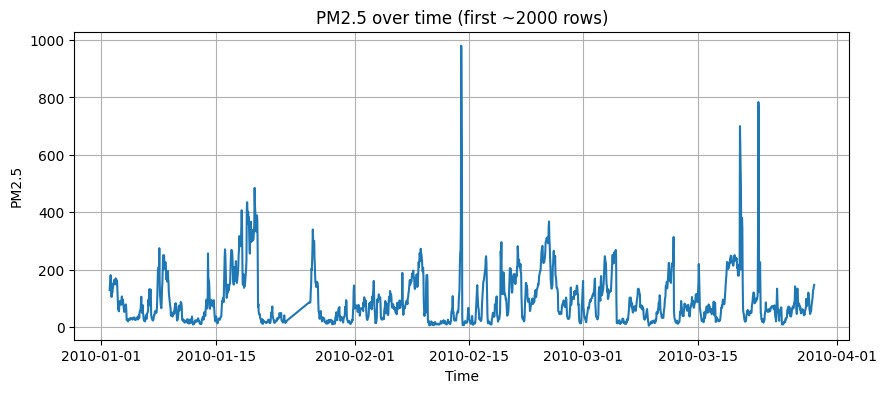

In [7]:
def ensure_datetime_sorted(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "datetime" in df.columns:
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        df = df.sort_values("datetime").reset_index(drop=True)
    return df

train = ensure_datetime_sorted(train)
test = ensure_datetime_sorted(test)

if "datetime" in train.columns:
    tmp = train[["datetime", TARGET]].dropna().iloc[:2000]
    plt.figure(figsize=(10,4))
    plt.plot(tmp["datetime"], tmp[TARGET])
    plt.title("PM2.5 over time (first ~2000 rows)")
    plt.xlabel("Time")
    plt.ylabel("PM2.5")
    plt.grid(True)
    plt.show()


## Preprocessing & Feature Engineering

Steps:
1. Remove rows where target PM2.5 is missing (training cannot learn without labels).
2. Extract time-based features (hour, day-of-week, month).
3. Drop non-feature identifier columns (e.g., `No`) and raw `datetime` after feature extraction.
4. Keep numeric features only (safe for modeling).
5. Impute missing feature values using **median** (robust to outliers).
6. Scale features using **StandardScaler** (helps neural network training).


In [8]:
# 1) Drop rows where target is missing
train = train.dropna(subset=[TARGET]).reset_index(drop=True)

# 2) Time features
def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "datetime" in df.columns:
        df["hour"] = df["datetime"].dt.hour
        df["dayofweek"] = df["datetime"].dt.dayofweek
        df["month"] = df["datetime"].dt.month
    return df

train = add_time_features(train)
test  = add_time_features(test)

train.head()


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5,hour,dayofweek,month
0,25,-1.234456,-1.348408,0.345943,-0.441894,-0.069353,-0.137667,2010-01-02 00:00:00,-0.690542,1.366085,-0.522096,129.0,0,5,1
1,26,-1.165172,-1.348408,0.345943,-0.424097,-0.069353,-0.137667,2010-01-02 01:00:00,-0.690542,1.366085,-0.522096,148.0,1,5,1
2,27,-0.888034,-1.430386,0.443328,-0.406301,-0.069353,-0.137667,2010-01-02 02:00:00,-0.690542,1.366085,-0.522096,159.0,2,5,1
3,28,-0.610897,-1.430386,0.540712,-0.370508,1.245803,-0.137667,2010-01-02 03:00:00,-0.690542,1.366085,-0.522096,181.0,3,5,1
4,29,-0.610897,-1.430386,0.540712,-0.352712,2.560959,-0.137667,2010-01-02 04:00:00,-0.690542,1.366085,-0.522096,138.0,4,5,1


In [9]:
DROP_COLS = []
if "No" in train.columns: DROP_COLS.append("No")
if "No" in test.columns:  DROP_COLS.append("No")

# y
y = train[TARGET].astype("float32").values

# X
X_train = train.drop(columns=[TARGET] + DROP_COLS, errors="ignore")
X_test  = test.drop(columns=DROP_COLS, errors="ignore")

# Remove raw datetime
X_train = X_train.drop(columns=["datetime"], errors="ignore")
X_test  = X_test.drop(columns=["datetime"], errors="ignore")

X_train = X_train.select_dtypes(include=[np.number])
X_test  = X_test.select_dtypes(include=[np.number])

X_test = X_test.reindex(columns=X_train.columns, fill_value=np.nan)

print("X_train:", X_train.shape, "X_test:", X_test.shape, "y:", y.shape)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp).astype("float32")
X_test_scaled  = scaler.transform(X_test_imp).astype("float32")

print("Scaled shapes:", X_train_scaled.shape, X_test_scaled.shape)


X_train: (28755, 12) X_test: (13148, 12) y: (28755,)
Scaled shapes: (28755, 12) (13148, 12)


In [11]:
def make_sequences(X, y=None, window=24):
    """
    Builds sequences:
      X_seq[i] = X[i-window : i]
      y_seq[i] = y[i]  (predict current point from previous window points)

    Output:
      X_seq shape: (n-window, window, n_features)
      y_seq shape: (n-window,) if y provided
    """
    n = X.shape[0]
    X_seq = []
    y_seq = [] if y is not None else None

    for i in range(window, n):
        X_seq.append(X[i-window:i])
        if y is not None:
            y_seq.append(y[i])

    X_seq = np.array(X_seq, dtype=np.float32)
    if y is None:
        return X_seq, None
    return X_seq, np.array(y_seq, dtype=np.float32)


In [13]:
WINDOW = 48
Xw, yw = make_sequences(X_train_scaled, y=y, window=WINDOW)
print(Xw.shape, yw.shape)


(28707, 48, 12) (28707,)


In [14]:
# last 20% for validation (time-aware)
n = len(Xw)
split = int(n * 0.8)

X_tr, X_val = Xw[:split], Xw[split:]
y_tr, y_val = yw[:split], yw[split:]

print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)


(22965, 48, 12) (22965,) (5742, 48, 12) (5742,)


## Metric: RMSE

RMSE (Root Mean Squared Error) measures the average magnitude of prediction error:

\[
RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y}_i)^2}
\]

Lower RMSE indicates better predictive performance.


In [15]:
def build_lstm_model(input_shape, lstm_units=64, dense_units=32, lr=1e-3, dropout=0.0):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(lstm_units, activation="tanh", dropout=dropout),
        layers.Dense(dense_units, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

model = build_lstm_model(
    input_shape=(X_tr.shape[1], X_tr.shape[2]),
    lstm_units=64,
    dense_units=32,
    lr=1e-3,
    dropout=0.1
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cb = [
    callbacks.EarlyStopping(monitor="val_rmse", patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_rmse", patience=2, factor=0.5, min_lr=1e-5)
]

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    callbacks=cb,
    verbose=1
)


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 16463.4961 - rmse: 128.2784 - val_loss: 16581.3242 - val_rmse: 128.7685 - learning_rate: 0.0010
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 10017.8809 - rmse: 100.0521 - val_loss: 12051.7227 - val_rmse: 109.7803 - learning_rate: 0.0010
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 7418.2563 - rmse: 86.1086 - val_loss: 9513.7373 - val_rmse: 97.5384 - learning_rate: 0.0010
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - loss: 5870.3096 - rmse: 76.6139 - val_loss: 8270.6221 - val_rmse: 90.9430 - learning_rate: 0.0010
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 5308.3530 - rmse: 72.8565 - val_loss: 7718.4707 - val_rmse: 87.8548 - learning_rate: 0.0010
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 5066.1772 - rmse: 71.1754 - val_loss: 7190.0034 - val_rmse: 84.7939 - learning_rate: 0.0010
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - loss: 4663.7949 - r

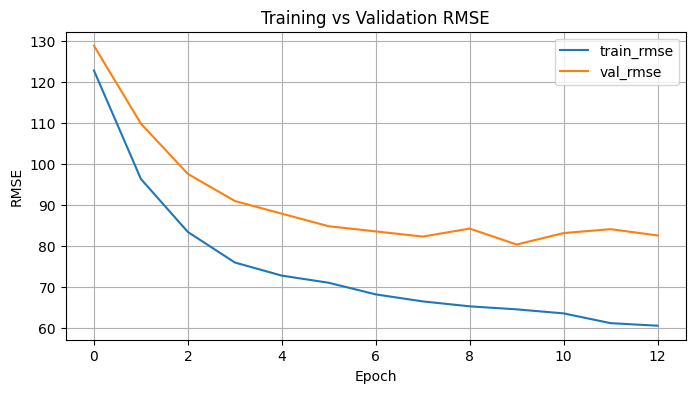

Best val RMSE: 80.35064697265625


In [17]:
plt.figure(figsize=(8,4))
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("Training vs Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

best_val = np.min(history.history["val_rmse"])
print("Best val RMSE:", best_val)


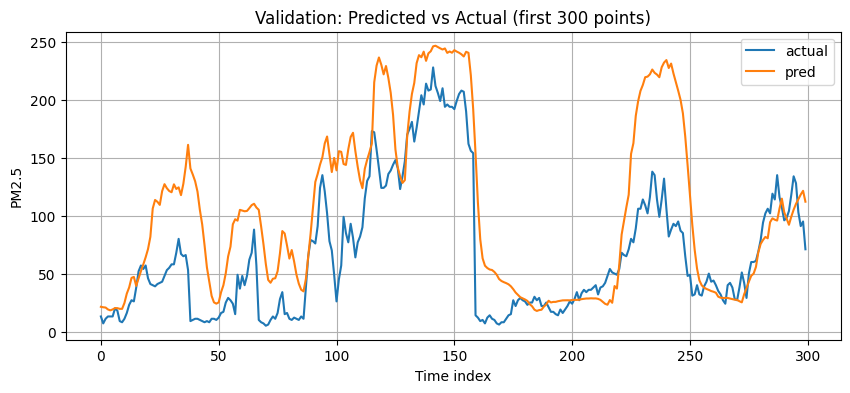

In [18]:
val_pred = model.predict(X_val, verbose=0).reshape(-1)

plt.figure(figsize=(10,4))
plt.plot(y_val[:300], label="actual")
plt.plot(val_pred[:300], label="pred")
plt.title("Validation: Predicted vs Actual (first 300 points)")
plt.xlabel("Time index")
plt.ylabel("PM2.5")
plt.grid(True)
plt.legend()
plt.show()


## Experiment Table

We run multiple experiments by varying:
- window size
- LSTM units
- dense units
- learning rate
- batch size
- dropout

We record the **best validation RMSE** from each run.


In [24]:
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import callbacks

print("GPUs:", tf.config.list_physical_devices("GPU"))

def run_experiment(cfg):
    """
    Trains one model configuration and returns best validation RMSE.
    Assumes you already have:
      - make_sequences()
      - build_lstm_model()
      - X_train_scaled, y
    """
    # 1) Build sequences
    window = int(cfg["window"])
    Xw, yw = make_sequences(X_train_scaled, y=y, window=window)

    limit = int(len(Xw) * 0.6)
    Xw = Xw[:limit]
    yw = yw[:limit]

    # 2) Time-aware split
    n = len(Xw)
    split = int(n * 0.8)
    X_tr, X_val = Xw[:split], Xw[split:]
    y_tr, y_val = yw[:split], yw[split:]

    # 3) Build model
    model = build_lstm_model(
        input_shape=(X_tr.shape[1], X_tr.shape[2]),
        lstm_units=int(cfg["lstm_units"]),
        dense_units=int(cfg["dense_units"]),
        lr=float(cfg["lr"]),
        dropout=float(cfg["dropout"])
    )

    cb = [
        callbacks.EarlyStopping(monitor="val_rmse", patience=1, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_rmse", patience=1, factor=0.5, min_lr=1e-5),
    ]

    # 4) Train
    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=int(cfg["epochs"]),
        batch_size=int(cfg["batch_size"]),
        callbacks=cb,
        verbose=0
    )

    best_val = float(np.min(hist.history["val_rmse"]))

    # 5) Cleanup (prevents slowdown across many experiments)
    tf.keras.backend.clear_session()
    gc.collect()

    return best_val


# -----------------------------
# Define configs (15+)
# -----------------------------
configs = [
    {"exp":"E1",  "window":12, "lstm_units":32,  "dense_units":16, "lr":1e-3,  "batch_size":256, "dropout":0.0, "epochs":8},
    {"exp":"E2",  "window":24, "lstm_units":32,  "dense_units":16, "lr":1e-3,  "batch_size":256, "dropout":0.0, "epochs":8},
    {"exp":"E3",  "window":24, "lstm_units":64,  "dense_units":32, "lr":1e-3,  "batch_size":256, "dropout":0.1, "epochs":10},
    {"exp":"E4",  "window":48, "lstm_units":64,  "dense_units":32, "lr":1e-3,  "batch_size":256, "dropout":0.1, "epochs":10},
    {"exp":"E5",  "window":24, "lstm_units":64,  "dense_units":64, "lr":1e-3,  "batch_size":256, "dropout":0.1, "epochs":10},
    {"exp":"E6",  "window":24, "lstm_units":64,  "dense_units":32, "lr":5e-4,  "batch_size":256, "dropout":0.1, "epochs":12},
    {"exp":"E7",  "window":24, "lstm_units":128, "dense_units":64, "lr":1e-3,  "batch_size":256, "dropout":0.2, "epochs":10},
    {"exp":"E8",  "window":24, "lstm_units":64,  "dense_units":32, "lr":1e-4,  "batch_size":256, "dropout":0.1, "epochs":12},
    {"exp":"E9",  "window":24, "lstm_units":64,  "dense_units":32, "lr":1e-3,  "batch_size":128, "dropout":0.1, "epochs":10},
    {"exp":"E10", "window":48, "lstm_units":128, "dense_units":64, "lr":5e-4,  "batch_size":128, "dropout":0.2, "epochs":12},

    {"exp":"E11", "window":72, "lstm_units":64,  "dense_units":32, "lr":5e-4,  "batch_size":256, "dropout":0.1, "epochs":12},
    {"exp":"E12", "window":48, "lstm_units":96,  "dense_units":32, "lr":5e-4,  "batch_size":256, "dropout":0.1, "epochs":12},
    {"exp":"E13", "window":48, "lstm_units":128, "dense_units":64, "lr":3e-4,  "batch_size":128, "dropout":0.2, "epochs":12},
    {"exp":"E14", "window":24, "lstm_units":64,  "dense_units":32, "lr":3e-4,  "batch_size":256, "dropout":0.2, "epochs":12},
    {"exp":"E15", "window":96, "lstm_units":64,  "dense_units":32, "lr":5e-4,  "batch_size":128, "dropout":0.1, "epochs":12},
    {"exp":"E16", "window":48, "lstm_units":64,  "dense_units":64, "lr":5e-4,  "batch_size":128, "dropout":0.3, "epochs":12},
]


results = []

for cfg in configs:
    best_rmse = run_experiment(cfg)
    row = cfg.copy()
    row["best_val_rmse"] = best_rmse
    results.append(row)
    print(f"{cfg['exp']} -> best val RMSE: {best_rmse:.4f}")

exp_table = pd.DataFrame(results).sort_values("best_val_rmse").reset_index(drop=True)
display(exp_table)

# Save to Drive
exp_out = DATA_DIR / "experiment_table.csv"
exp_table.to_csv(exp_out, index=False)
print("Saved experiment table to:", exp_out)


GPUs: []
E1 -> best val RMSE: 106.4625
E2 -> best val RMSE: 112.8393
E3 -> best val RMSE: 84.7488
E4 -> best val RMSE: 86.9715
E5 -> best val RMSE: 87.0248
E6 -> best val RMSE: 91.2268
E7 -> best val RMSE: 86.7573
E8 -> best val RMSE: 139.9702
E9 -> best val RMSE: 86.8488
E10 -> best val RMSE: 80.9670
E11 -> best val RMSE: 97.0119
E12 -> best val RMSE: 89.9367
E13 -> best val RMSE: 82.5338
E14 -> best val RMSE: 106.9727
E15 -> best val RMSE: 83.9697
E16 -> best val RMSE: 84.4890


,exp,window,lstm_units,dense_units,lr,batch_size,dropout,epochs,best_val_rmse
0,E10,48,128,64,0.0005,128,0.2,12,80.967041
1,E13,48,128,64,0.0003,128,0.2,12,82.533821
2,E15,96,64,32,0.0005,128,0.1,12,83.969658
3,E16,48,64,64,0.0005,128,0.3,12,84.488991
4,E3,24,64,32,0.0010,256,0.1,10,84.748833
5,E7,24,128,64,0.0010,256,0.2,10,86.757271
6,E9,24,64,32,0.0010,128,0.1,10,86.848793
7,E4,48,64,32,0.0010,256,0.1,10,86.971542
8,E5,24,64,64,0.0010,256,0.1,10,87.024811
9,E12,48,96,32,0.0005,256,0.1,12,89.936668


Saved experiment table to: /content/drive/MyDrive/MyDrive air-quality data /experiment_table.csv


In [25]:
exp_out = DATA_DIR / "experiment_table.csv"
exp_table.to_csv(exp_out, index=False)
print("Saved experiment table to:", exp_out)


Saved experiment table to: /content/drive/MyDrive/MyDrive air-quality data /experiment_table.csv


## Results & Discussion

From the experiment table, we observe that:
- Larger window sizes (e.g., 24–48) often improve performance because the model sees more recent history.
- Increasing LSTM units can help capture complex patterns, but too many units may overfit or slow training.
- Lower learning rates can stabilize training, but may converge slowly.

### Overfitting / Underfitting
A widening gap between training RMSE and validation RMSE suggests overfitting. Early stopping and learning-rate scheduling were used to reduce overfitting.

### RNN challenges (vanishing/exploding gradients)
Standard RNNs can suffer from **vanishing gradients** when learning long dependencies. LSTMs mitigate this using gating mechanisms (forget/input/output gates) that preserve and control information flow. Additionally, learning-rate reduction and early stopping help stabilize training.


In [26]:
# ============================
# FINAL TRAIN + KAGGLE SUBMISSION
# ============================

# 1) Pick best experiment (lowest validation RMSE)
best_cfg = exp_table.sort_values("best_val_rmse").iloc[0].to_dict()
print("Best config selected:", best_cfg)

WINDOW = int(best_cfg["window"])

# 2) Build FULL training sequences
Xw_full, yw_full = make_sequences(X_train_scaled, y=y, window=WINDOW)

print("Full train sequences:", Xw_full.shape, yw_full.shape)

# 3) Build test sequences correctly
X_combined = np.vstack([X_train_scaled[-WINDOW:], X_test_scaled])
Xw_test, _ = make_sequences(X_combined, y=None, window=WINDOW)

print("Test sequences:", Xw_test.shape, "Expected rows:", len(test))

# 4) Build + train final model
final_model = build_lstm_model(
    input_shape=(Xw_full.shape[1], Xw_full.shape[2]),
    lstm_units=int(best_cfg["lstm_units"]),
    dense_units=int(best_cfg["dense_units"]),
    lr=float(best_cfg["lr"]),
    dropout=float(best_cfg["dropout"])
)

cb = [
    callbacks.EarlyStopping(monitor="rmse", patience=3, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="rmse", patience=2, factor=0.5, min_lr=1e-5)
]

final_hist = final_model.fit(
    Xw_full, yw_full,
    epochs=int(best_cfg["epochs"]),
    batch_size=int(best_cfg["batch_size"]),
    callbacks=cb,
    verbose=1
)

print("Final train best RMSE:", float(np.min(final_hist.history["rmse"])))

# 5) Predict test and save submission
preds = final_model.predict(Xw_test, verbose=0).reshape(-1)
preds = np.clip(preds, 0, None)

submission = sample_sub.copy()

pred_col = "pm2.5" if "pm2.5" in submission.columns else submission.columns[-1]
submission[pred_col] = preds

tag = f"w{WINDOW}_u{int(best_cfg['lstm_units'])}_lr{best_cfg['lr']}_bs{int(best_cfg['batch_size'])}_do{best_cfg['dropout']}"
out_path = DATA_DIR / f"submission_{tag}.csv"

submission.to_csv(out_path, index=False)
print("Saved submission to:", out_path)

submission.head()


Best config selected: {'exp': 'E10', 'window': 48, 'lstm_units': 128, 'dense_units': 64, 'lr': 0.0005, 'batch_size': 128, 'dropout': 0.2, 'epochs': 12, 'best_val_rmse': 80.967041015625}
Full train sequences: (28707, 48, 12) (28707,)
Test sequences: (13148, 48, 12) Expected rows: 13148
Epoch 1/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - loss: 15793.1152 - rmse: 125.3628 - learning_rate: 5.0000e-04
Epoch 2/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - loss: 7012.7939 - rmse: 83.6803 - learning_rate: 5.0000e-04
Epoch 3/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - loss: 5857.2222 - rmse: 76.5002 - learning_rate: 5.0000e-04
Epoch 4/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - loss: 5359.5991 - rmse: 73.1755 - learning_rate: 5.0000e-04
Epoch 5/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - loss: 4932.6777 - rmse: 70.1954 - learning_rate: 5.0000e-04
Epoch 6/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - loss: 4682.8745 - rmse: 68.3832 - learning_rate: 5.0000e-04
Epoch 7/12

,row ID,pm2.5
0,2013-07-02 4:00:00,45.056217
1,2013-07-02 5:00:00,43.862667
2,2013-07-02 6:00:00,39.911270
3,2013-07-02 7:00:00,36.181309
4,2013-07-02 8:00:00,32.515751


In [27]:
preds = final_model.predict(Xw_test, verbose=0).reshape(-1)
preds = np.clip(preds, 0, None)

submission = sample_sub.copy()
submission["pm2.5"] = preds

print(submission.columns)
print(submission.head())

submission.to_csv(DATA_DIR/"submission.csv", index=False)


Index(['row ID', 'pm2.5'], dtype='object')
               row ID      pm2.5
0  2013-07-02 4:00:00  45.056217
1  2013-07-02 5:00:00  43.862667
2  2013-07-02 6:00:00  39.911270
3  2013-07-02 7:00:00  36.181309
4  2013-07-02 8:00:00  32.515751


In [28]:
a = pd.to_datetime(sample_sub["row ID"])
b = pd.to_datetime(test["datetime"])
print("Same order?", (a.reset_index(drop=True) == b.reset_index(drop=True)).all())


Same order? True


In [29]:
print(len(submission), len(sample_sub))
print(submission.isna().sum())


13148 13148
row ID    0
pm2.5     0
dtype: int64


In [30]:
print(submission["pm2.5"].describe())


count    13148.000000
mean       102.988716
std         67.806725
min          2.526361
25%         55.144239
50%         91.052452
75%        129.105568
max        380.194824
Name: pm2.5, dtype: float64


**Conclusion**

This project demonstrated the effectiveness of LSTM based models for time series forecasting of PM2.5 air pollution levels. By combining time aware preprocessing, feature engineering, and sequence windowing, the model was able to capture temporal dependencies inherent in air quality data and produce meaningful short-term forecasts.

Key performance improvements were achieved through the extraction of temporal features hour, day of week, and month, robust handling of missing values and scaling, and the use of sliding windows to preserve sequential context. Systematic hyperparameter experimentation, tracked through an experiment table, further highlighted the importance of window size, model capacity, and regularization in balancing predictive accuracy and generalization.

While the model achieved competitive performance on the Kaggle leaderboard, the results also revealed inherent variability in neural network training and sensitivity to configuration choices. In particular, moderate window sizes consistently outperformed very short or excessively long windows, reinforcing the importance of recent historical context for PM2.5 prediction.

Future work could explore deeper or stacked LSTM architectures, attention mechanisms, and additional engineered features such as lag variables and rolling statistics. Incorporating external data sources, including meteorological or emissions data, may further improve predictive accuracy and robustness in real-world air quality forecasting applications.